In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

In [4]:
from imblearn.combine import SMOTEENN
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier 
from imblearn.metrics import classification_report_imbalanced
from imblearn.under_sampling import ClusterCentroids

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Read the CSV and Perform Basic Data Cleaning

In [5]:
# https://help.lendingclub.com/hc/en-us/articles/215488038-What-do-the-different-Note-statuses-mean-

columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

In [6]:
# Load the data
file_path = Path('LoanStats_2019Q1.csv')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df = df.loc[:, columns].copy()

# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()

# Remove the `Issued` loan status
issued_mask = df['loan_status'] != 'Issued'
df = df.loc[issued_mask]

# convert interest rate to numerical
df['int_rate'] = df['int_rate'].str.replace('%', '')
df['int_rate'] = df['int_rate'].astype('float') / 100


# Convert the target column values to low_risk and high_risk based on their values
x = {'Current': 'low_risk'}   
df = df.replace(x)

x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period'], 'high_risk')    
df = df.replace(x)

df.reset_index(inplace=True, drop=True)

df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


# Split the Data into Training and Testing

In [7]:
# grab the features you are going to use
X = df.drop(columns="loan_status", axis = 1)
X = pd.get_dummies(X)
X
# name your target
y = df["loan_status"]

In [8]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.0,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,68817.0
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.177238,1.0,0.123879,0.876121,0.383161,0.616839,0.860340,0.139660,1.0,1.0
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.381873,0.0,0.329446,0.329446,0.486161,0.486161,0.346637,0.346637,0.0,0.0
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.0,1.0
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.0,1.0
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,0.000000,1.0,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.0,1.0
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0


In [9]:
# check the balance of our target values
y.value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [10]:
# get test and training data sets 
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1, 
                                                    stratify=y)

# Ensemble Learners

In this section, you will compare two ensemble algorithms to determine which algorithm results in the best performance. You will train a Balanced Random Forest Classifier and an Easy Ensemble AdaBoost classifier . For each algorithm, be sure to complete the folliowing steps:

1. Train the model using the training data. 
2. Calculate the balanced accuracy score from sklearn.metrics.
3. Print the confusion matrix from sklearn.metrics.
4. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.
5. For the Balanced Random Forest Classifier onely, print the feature importance sorted in descending order (most important feature to least important) along with the feature score

Note: Use a random state of 1 for each algorithm to ensure consistency between tests

### Balanced Random Forest Classifier

In [11]:
# Resample the training data with the BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=1)
brf.fit(X_train, y_train)

y_pred_brf = brf.predict(X_test)

In [12]:
# Calculated the balanced accuracy score
print("Balanced Random Forest classifier accuracy:")
print(f"Balanced accuracy: {balanced_accuracy_score(y_test, y_pred_brf):.4f}")

Balanced Random Forest classifier accuracy:
Balanced accuracy: 0.7878


In [13]:
# Display the confusion matrix
# display the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred_brf)

array([[   58,    29],
       [ 1560, 15558]])

In [14]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred_brf))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.04      0.67      0.91      0.07      0.78      0.59        87
   low_risk       1.00      0.91      0.67      0.95      0.78      0.62     17118

avg / total       0.99      0.91      0.67      0.95      0.78      0.62     17205



In [15]:
# List the features sorted in descending order by feature importance
importances = brf.feature_importances_
importances

array([0.00982912, 0.02458052, 0.01698703, 0.01661322, 0.01862588,
       0.00452388, 0.00475626, 0.00776032, 0.00141858, 0.01492449,
       0.01048004, 0.02039888, 0.01533707, 0.05811196, 0.06073336,
       0.07376668, 0.06390324, 0.00639138, 0.        , 0.        ,
       0.04951778, 0.00069491, 0.        , 0.        , 0.00378968,
       0.01423847, 0.00600478, 0.00666004, 0.00524884, 0.0068764 ,
       0.01043385, 0.01351439, 0.013139  , 0.00541331, 0.00659981,
       0.01837888, 0.0130093 , 0.01119472, 0.00740497, 0.00794881,
       0.00970921, 0.00742067, 0.0150665 , 0.01334386, 0.01623198,
       0.        , 0.        , 0.01406737, 0.01458321, 0.01017148,
       0.00888343, 0.00639377, 0.01072809, 0.01582192, 0.00390292,
       0.00828741, 0.00781388, 0.00678543, 0.00939407, 0.00733951,
       0.00939096, 0.01192775, 0.00990082, 0.00784173, 0.        ,
       0.        , 0.00110461, 0.00606583, 0.01048577, 0.0079446 ,
       0.00152091, 0.        , 0.01310601, 0.01428231, 0.01538

In [16]:
# sort features by importance.
importance = sorted(zip(brf.feature_importances_, X.columns), reverse=True)
#print(importance)
importance_df = pd.DataFrame(importance,columns = ["Importance", "Feature"])
# p#rint(importance_df)

pd.set_option('display.max_rows', df.shape[0]+1)
importance_df[["Feature" , "Importance"]]

,Feature,Importance
0,total_rec_prncp,0.073767
1,total_rec_int,0.063903
2,total_pymnt_inv,0.060733
3,total_pymnt,0.058112
4,last_pymnt_amnt,0.049518
5,int_rate,0.024581
6,out_prncp,0.020399
7,dti,0.018626
8,max_bal_bc,0.018379
9,issue_d_Jan-2019,0.017480


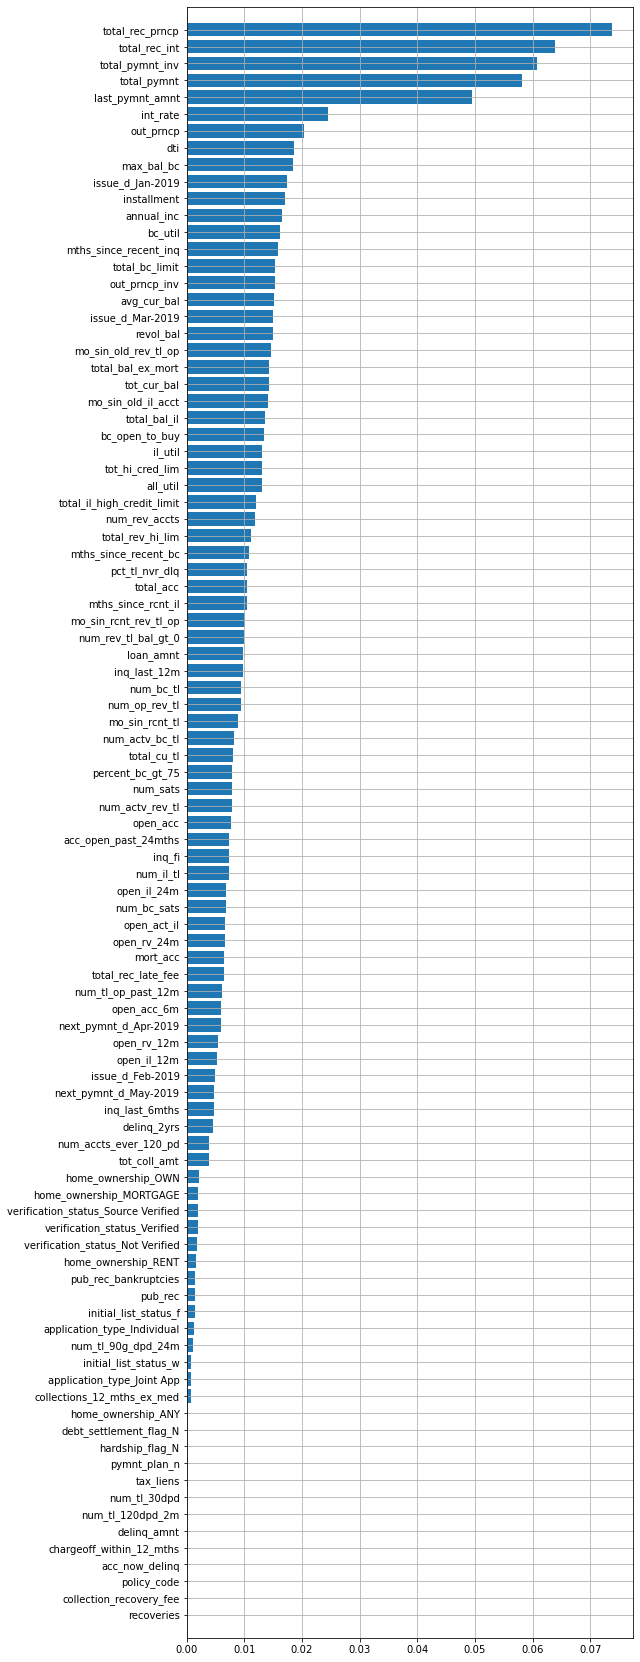

In [17]:
# plot importants of features
features = sorted(zip(X.columns, brf.feature_importances_), key = lambda x: x[1])
cols = [f[0] for f in features]
width = [f[1] for f in features]

fig, ax = plt.subplots()

fig.set_size_inches(8,30)
plt.margins(y=0.01)

ax.barh(y=cols, width=width)
ax.grid()

plt.show()

### Easy Ensemble AdaBoost Classifier

In [18]:
# Train the EasyEnsembleClassifier
eec = EasyEnsembleClassifier(n_estimators=100, random_state=1)
eec.fit(X_train, y_train)

EasyEnsembleClassifier(n_estimators=100, random_state=1)

In [19]:
# Calculated the balanced accuracy score
y_pred = eec.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.925427358175101

In [20]:
# Display the confusion matrix
print(confusion_matrix(y_test, y_pred))

[[   79     8]
 [  979 16139]]


In [21]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.07      0.91      0.94      0.14      0.93      0.85        87
   low_risk       1.00      0.94      0.91      0.97      0.93      0.86     17118

avg / total       0.99      0.94      0.91      0.97      0.93      0.86     17205

